In [1]:
#!unzip /content/drive/MyDrive/complaints.csv.zip

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
#print(os.listdir())

In [4]:
train = pd.read_excel('/kaggle/input/wgrhtjhfhbh/TrainV2.xlsx')
test = pd.read_excel('/kaggle/input/wgrhtjhfhbh/Test.xlsx')

In [5]:
train.shape

(93709, 2)

In [6]:
 train.head()

,Comments_Modified,Topic_level_2
0,Faster shipping.,Shipping.related
1,Let me talk with a live person when I have pri...,Want.live.person
2,"delivery went to wrong house, but that was fau...",Shipping.related
3,Hp need to provide a support pc while my pc wa...,Repair.Issue
4,- Improve the product quality at first place -...,Warranty.Related.Issue


In [7]:
#df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
train = train[pd.notnull(train['Comments_Modified'])]

# Renaming second column for a simpler name
#df1.columns = ['Product', 'Consumer_complaint'] 

#print(df1.shape)

In [8]:
#df1.head()

In [9]:
pd.DataFrame(train.Topic_level_2.unique()).values

array([['Shipping.related'],
       ['Want.live.person'],
       ['Repair.Issue'],
       ['Warranty.Related.Issue'],
       ['Issue.not.resolved'],
       ['No.Comment'],
       ['Hire.or.Train'],
       ['Chatbot.not.helpful'],
       ['Prefers.Onshore.Support'],
       ['Hold.or.Wait.time'],
       ['Laptop.or.Desktop.Issue'],
       ['Website.Related.Issue'],
       ['Refund.or.return.requested'],
       ['Disconnect.or.Technical.Issue'],
       ['Communication.or.Language.barrier'],
       ['Want.phone.or.contact'],
       ['Printer.issue'],
       ['Agent.Appreciation'],
       ['Instant.ink.issues'],
       ['Customer.Suggestion'],
       ['Unhappy.with.CS'],
       ['Happy.with.CS.or.HP'],
       ['Printer.Issue']], dtype=object)

In [10]:
#df2 = df1.sample(10000, random_state=1).copy()

In [11]:
import re
from nltk.tokenize import RegexpTokenizer
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    return " ".join(tokens)

In [12]:
train['Clean_text'] = train['Comments_Modified'].apply(preprocess)

In [13]:
pd.DataFrame(train.Topic_level_2.unique())

,0
0,Shipping.related
1,Want.live.person
2,Repair.Issue
3,Warranty.Related.Issue
4,Issue.not.resolved
5,No.Comment
6,Hire.or.Train
7,Chatbot.not.helpful
8,Prefers.Onshore.Support
9,Hold.or.Wait.time


In [14]:
# Create a new column 'category_id' with encoded categories 
train['category_id'] = train['Topic_level_2'].factorize()[0]
category_id_df = train[['Topic_level_2', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Topic_level_2']].values)

# New dataframe
train.head()

,Comments_Modified,Topic_level_2,Clean_text,category_id
0,Faster shipping.,Shipping.related,faster shipping,0
1,Let me talk with a live person when I have pri...,Want.live.person,let me talk with a live person when i have pri...,1
2,"delivery went to wrong house, but that was fau...",Shipping.related,delivery went to wrong house but that was faul...,0
3,Hp need to provide a support pc while my pc wa...,Repair.Issue,hp need to provide a support pc while my pc wa...,2
4,- Improve the product quality at first place -...,Warranty.Related.Issue,improve the product quality at first place if ...,3


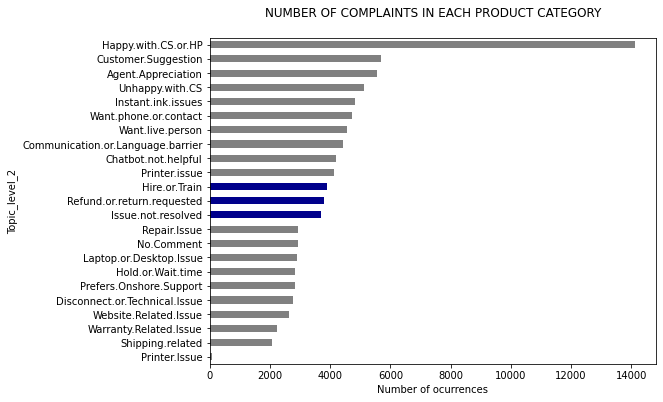

In [15]:

fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
train.groupby('Topic_level_2').Comments_Modified.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english',lowercase=False)

# We transform each complaint into a vector
features = tfidf.fit_transform(train.Clean_text).toarray()

labels = train.category_id

print("Each of the %d comments is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 93037 comments is represented by 32915 features (TF-IDF score of unigrams and bigrams)


In [17]:
X = train['Clean_text'] # Collection of documents
y = train['Topic_level_2'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [18]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

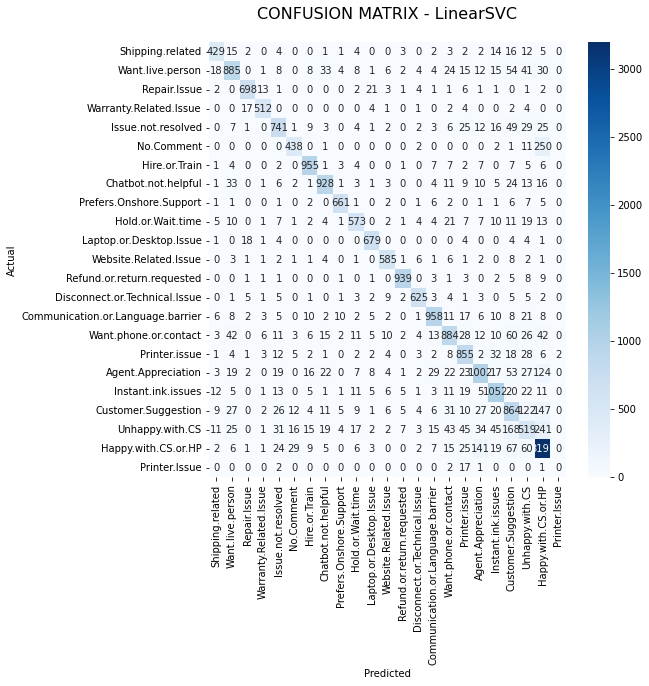

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Topic_level_2.values, 
            yticklabels=category_id_df.Topic_level_2.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [21]:
pred = model.predict(fitted_vectorizer.transform(list(X_test)))

In [22]:

from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.8190885640584695

In [23]:
complaint = """People who speak english."""

print(model.predict(fitted_vectorizer.transform([complaint])))

['Communication.or.Language.barrier']


In [24]:
test['Clean_text'] = test['Comments_Modified'].apply(preprocess)

In [25]:
pred_sentences = list(test['Clean_text'])

In [26]:
predictions = model.predict(fitted_vectorizer.transform(pred_sentences))

In [27]:
predictions[110]

'Happy.with.CS.or.HP'

In [28]:
enc_labels = []
act_labels = []
for i in range(len(predictions)):
  enc_labels.append(predictions[i][2])
  act_labels.append(predictions[i][3])

In [29]:
dtm = pd.DataFrame(predictions, columns = ['level2coded'])

In [30]:
dtm.shape

(1309, 1)

In [31]:
dtm.head()

,level2coded
0,No.Comment
1,Happy.with.CS.or.HP
2,Instant.ink.issues
3,Issue.not.resolved
4,Happy.with.CS.or.HP


In [32]:
dtm.reset_index(drop = True, inplace = True)


In [33]:
final = pd.concat([test, dtm], axis =1 )

In [34]:
final.reset_index(drop = True, inplace = True)

In [35]:
final.head(30)

,Orc Id,Comments_Modified,Clean_text,level2coded
0,280650823,Everything was ok.,everything was ok,No.Comment
1,282653777,no,no,Happy.with.CS.or.HP
2,290186062,Make your instant ink plans add more printed c...,make your instant ink plans add more printed c...,Instant.ink.issues
3,290287350,I will waite until my problem is resolved.,i will waite until my problem is resolved,Issue.not.resolved
4,290288097,no,no,Happy.with.CS.or.HP
5,290290928,no,no,Happy.with.CS.or.HP
6,290303927,Hours are too limited and the virtual help age...,hours are too limited and the virtual help age...,Chatbot.not.helpful
7,290441110,The app is not user friendly or intuitive. It ...,the app is not user friendly or intuitive it w...,Unhappy.with.CS
8,290443668,"No, just keep doing good until the good gets b...",no just keep doing good until the good gets be...,Happy.with.CS.or.HP
9,290447975,no,no,Happy.with.CS.or.HP


In [36]:
final.to_excel('HP_tag.xlsx')